# Optimizing Tor Circuit Selection Using Proximal Policy Optimization

**CS 6367 - Reinforcement Learning Final Project**  
**Preston Horne | Vanderbilt University | December 2025**

## Project Overview

The Tor anonymity network routes traffic through three-relay circuits (guard, middle, exit) to protect user privacy. This notebook applies Proximal Policy Optimization (PPO) to learn circuit selection policies that improve performance while maintaining the stochasticity essential for anonymity.

AI (Claude Opus 4.5 LLM) was used to assist with code implementation and documentation. The research design, experimental methodology, and analysis are my own work.

**Key Features:**
- Custom Gymnasium environment simulating 500 Tor relays with realistic parameters
- PPO agent with action masking to enforce Tor specification constraints
- Comparison against Tor's bandwidth-weighted selection baseline
- Entropy-based anonymity metrics to verify policy stochasticity

## Table of Contents
1. [Setup and Configuration](#1-setup-and-configuration)
2. [Environment Implementation](#2-environment-implementation)
3. [PPO Agent Implementation](#3-ppo-agent-implementation)
4. [Baseline Agent (Tor's Default Algorithm)](#4-baseline-agent)
5. [Training](#5-training)
6. [Evaluation and Results](#6-evaluation-and-results)
7. [Visualization](#7-visualization)
8. [Analysis and Discussion](#8-analysis-and-discussion)

## 1. Setup and Configuration

First, we import the necessary libraries and define our configuration parameters.

In [1]:
# Core imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium as gym
from gymnasium import spaces
from collections import deque, Counter
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.9.0
NumPy version: 2.3.4
Device: cpu


In [ ]:
# ============================================================================
# CONFIGURATION
# Based on real Tor network statistics from metrics.torproject.org
# Data fetched via Onionoo API on December 9, 2025
# ============================================================================

# Environment parameters
ENV_NUM_RELAYS = 500
ENV_GUARD_FRACTION = 0.642      # Real Tor (Dec 2025): 6,152/9,578 = 64.2% have Guard flag
ENV_EXIT_FRACTION = 0.302       # Real Tor (Dec 2025): 2,896/9,578 = 30.2% have Exit flag

# Tor relay flags (per dir-spec flag assignment)
ENV_FAST_FRACTION = 0.94        # Real: ~94% of relays have Fast flag
ENV_STABLE_FRACTION = 0.94      # Real: ~94% of relays have Stable flag
ENV_BADEXIT_FRACTION = 0.02     # ~2% of exits are marked BadExit

# Circuit requirements (per path-spec)
REQUIRE_FAST_FLAG = True        # Required for non-testing circuits
EXCLUDE_BADEXIT = True          # Exclude BadExit-flagged relays

# Relay bandwidth - REAL TOR NETWORK DISTRIBUTION (Dec 2025)
# From Onionoo API observed_bandwidth field (9,577 running relays):
#   p25:  4.88 MB/s
#   p50: 11.88 MB/s (median)
#   p75: 23.90 MB/s
#   p95: 48.09 MB/s
#   max: 124.73 MB/s
# We use these percentiles to sample from the empirical distribution
RELAY_BW_P25 = 4.88             # 25th percentile (MB/s)
RELAY_BW_P50 = 11.88            # Median (MB/s)
RELAY_BW_P75 = 23.90            # 75th percentile (MB/s)
RELAY_BW_P95 = 48.09            # 95th percentile (MB/s)
RELAY_MIN_BANDWIDTH = 0.1       # 100 KB/s minimum (real requirement)
RELAY_MAX_BANDWIDTH = 125.0     # ~125 MB/s max observed

# Latency parameters (realistic for global network)
RELAY_MIN_LATENCY = 10.0        # 10ms minimum
RELAY_MAX_LATENCY = 500.0       # 500ms maximum

# Network dynamics
RELAY_FAILURE_RATE = 0.05
RELAY_RECOVERY_RATE = 0.1
ENABLE_CONGESTION = True       
CONGESTION_VARIANCE = 0.2     

# Guard rotation - Real Tor: ~120 days
ENABLE_GUARD_ROTATION = True
GUARD_ROTATION_INTERVAL = 500

# Diversity constraints
ENABLE_GEOGRAPHIC_DIVERSITY = True
NUM_GEOGRAPHIC_REGIONS = 10
NUM_OPERATORS = 50
ENABLE_SUBNET_CONSTRAINTS = True   
ENABLE_FAMILY_CONSTRAINTS = True    
ENABLE_AS_DIVERSITY = True          
NUM_SUBNETS = 200                   
NUM_AS = 50                       
NUM_RELAY_FAMILIES = 20            
FAMILY_PROBABILITY = 0.3            

# Time-of-day variation
ENABLE_TIME_OF_DAY = True           
EPISODES_PER_HOUR = 100             
PEAK_HOUR_START = 18                
PEAK_HOUR_END = 23                 
PEAK_BANDWIDTH_FACTOR = 1.4
LOW_HOUR_START = 3
LOW_HOUR_END = 8
LOW_BANDWIDTH_FACTOR = 0.7

# Reward configuration - BALANCED for both bandwidth AND latency improvement
# Tuned to achieve ~30-50% improvement on both metrics vs Tor baseline
# Uses logarithmic bandwidth to prevent over-optimization
REWARD_INVALID_ACTION = -10.0
REWARD_BANDWIDTH_WEIGHT = 6.0       # Log-scaled bandwidth reward
REWARD_LATENCY_WEIGHT = -8.0        # Latency penalty
REWARD_DIVERSITY_WEIGHT = 15.0      # Diversity bonus
REWARD_AS_DIVERSITY_BONUS = 3.0     # AS diversity bonus
USE_LOG_BANDWIDTH = True            # Use log(bw) for diminishing returns
ANONYMITY_HISTORY_SIZE = 100

# Training parameters
TRAIN_NUM_EPISODES = 20000
TRAIN_LOG_FREQ = 500

# PPO hyperparameters
PPO_LEARNING_RATE = 0.0003
PPO_DISCOUNT_FACTOR = 0.99
PPO_GAE_LAMBDA = 0.95
PPO_CLIP_EPSILON = 0.2
PPO_ENTROPY_COEF = 0.01  # Standard value for entropy regularization
PPO_MAX_GRAD_NORM = 0.5
PPO_EPOCHS = 4
PPO_MINI_BATCH_SIZE = 64
PPO_ROLLOUT_STEPS = 2048

print("Configuration loaded successfully!")
print(f"  - Network size: {ENV_NUM_RELAYS} relays")
print(f"  - Guard fraction: {ENV_GUARD_FRACTION*100:.1f}% (real Tor: 64.2%)")
print(f"  - Exit fraction: {ENV_EXIT_FRACTION*100:.1f}% (real Tor: 30.2%)")
print(f"  - Bandwidth distribution from real Tor network (median: {RELAY_BW_P50} MB/s)")
print(f"  - Reward weights: BW={REWARD_BANDWIDTH_WEIGHT} (log), Lat={REWARD_LATENCY_WEIGHT}, Div={REWARD_DIVERSITY_WEIGHT}")
print(f"  - Training episodes: {TRAIN_NUM_EPISODES}")

## 2. Environment Implementation

The `CircuitEnv` class implements a Gymnasium-compatible environment simulating Tor circuit construction.

### Selection Order (per Tor path-spec)
Per the Tor specification: *"We choose the exit node first, followed by the other nodes in the circuit."* With a persistent guard, the agent selects:
1. **Exit relay** (first action) - must have Exit flag, not BadExit
2. **Middle relay** (second action) - any Fast relay meeting constraints

### Constraints Enforced via Action Masking
- **/16 subnet diversity**: No two relays may share a /16 IPv4 prefix
- **Family restrictions**: Relays declaring the same family cannot be in the same circuit
- **Flag requirements**: Fast flag for all; Guard flag for entry; Exit flag for exit
- **BadExit exclusion**: Relays flagged as BadExit are never selected as exits

### Reward Function
The reward balances performance and anonymity:
- **Bandwidth reward**: Proportional to minimum relay bandwidth (bottleneck model)
- **Latency penalty**: Proportional to sum of relay latencies
- **Diversity bonus**: Rewards novel circuits relative to recent history
- **AS diversity bonus**: Extra reward for using 3 distinct autonomous systems

In [ ]:
def sample_empirical_bandwidth():
    """
    Sample bandwidth from the empirical Tor network distribution.
    
    Uses inverse transform sampling with linear interpolation between
    the observed percentiles from real Tor network data (Dec 2025).
    
    Real distribution (9,577 relays):
      p25:  4.88 MB/s
      p50: 11.88 MB/s
      p75: 23.90 MB/s
      p95: 48.09 MB/s
      max: 124.73 MB/s
    """
    # Percentile points and corresponding bandwidth values
    percentiles = np.array([0, 0.25, 0.50, 0.75, 0.95, 1.0])
    bandwidths = np.array([
        RELAY_MIN_BANDWIDTH,  # p0 (minimum)
        RELAY_BW_P25,         # p25: 4.88 MB/s
        RELAY_BW_P50,         # p50: 11.88 MB/s
        RELAY_BW_P75,         # p75: 23.90 MB/s
        RELAY_BW_P95,         # p95: 48.09 MB/s
        RELAY_MAX_BANDWIDTH   # p100: ~125 MB/s
    ])
    
    # Sample a random percentile and interpolate
    p = np.random.random()
    bandwidth = np.interp(p, percentiles, bandwidths)
    return bandwidth


class CircuitEnv(gym.Env):
    """
    Tor circuit construction environment following the Tor path-spec.
    
    SELECTION ORDER (per Tor spec):
    "We choose the exit node first, followed by the other nodes in the circuit."
    
    Since we use a persistent guard, the order becomes:
    1. Guard is pre-selected (persistent)
    2. Agent selects EXIT first
    3. Agent selects MIDDLE second
    
    Constraints enforced:
    - /16 subnet diversity (no two relays share a /16)
    - Relay family restrictions (no family members in same circuit)
    - Fast flag required for all relays
    - Guard flag required for entry, Exit flag for exit
    - BadExit relays excluded
    
    Simplifications vs real Tor:
    - Wxx weights are fixed defaults, not dynamically computed
    - Circuit bandwidth modeled as min(relay bandwidths)
    - No real TCP/congestion modeling
    """

    def __init__(self):
        super().__init__()

        self.num_relays = ENV_NUM_RELAYS
        self.relays = self._generate_relays()

        # Gymnasium spaces
        self.action_space = spaces.Discrete(self.num_relays)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(30,), dtype=np.float32
        )

        # Circuit state - following Tor spec order
        # Position 0: Select EXIT (Tor selects exit first)
        # Position 1: Select MIDDLE (after exit is chosen)
        self.persistent_guard = self._select_persistent_guard()
        self.entry_guard = None
        self.middle_relay = None
        self.exit_relay = None
        self.circuit_pos = 0  # 0 = selecting exit, 1 = selecting middle

        # Tracking
        self.circuit_history = deque(maxlen=ANONYMITY_HISTORY_SIZE)
        self.relay_status = np.ones(self.num_relays, dtype=bool)
        self.guard_rotation_counter = 0
        self.episode_count = 0
        self.hour_of_day = 0.0

    def _generate_single_relay(self, relay_id):
        """
        Generate a single relay with realistic properties.
        
        Bandwidth distribution from REAL Tor network data (Dec 2025):
        - Uses empirical distribution from Onionoo API (9,577 relays)
        - Percentiles: p25=4.88, p50=11.88, p75=23.90, p95=48.09 MB/s
        - Linear interpolation between percentile points
        """
        is_guard = np.random.random() < ENV_GUARD_FRACTION
        is_exit = np.random.random() < ENV_EXIT_FRACTION
        is_fast = np.random.random() < ENV_FAST_FRACTION
        is_stable = np.random.random() < ENV_STABLE_FRACTION
        is_badexit = is_exit and np.random.random() < ENV_BADEXIT_FRACTION

        # Guards must be Fast and Stable per Tor spec
        if is_guard:
            is_fast = True
            is_stable = True

        # Sample bandwidth from empirical Tor distribution
        bandwidth = sample_empirical_bandwidth()
        bandwidth = np.clip(bandwidth, RELAY_MIN_BANDWIDTH, RELAY_MAX_BANDWIDTH)

        latency = np.random.exponential(scale=80) + RELAY_MIN_LATENCY
        latency = min(latency, RELAY_MAX_LATENCY)

        relay = {
            'id': relay_id,
            'bandwidth': bandwidth,
            'base_bandwidth': bandwidth,
            'latency': latency,
            'guard_flag': is_guard,
            'exit_flag': is_exit,
            'fast_flag': is_fast,
            'stable_flag': is_stable,
            'badexit_flag': is_badexit,
            'subnet': np.random.randint(0, NUM_SUBNETS),
            'as_number': np.random.randint(0, NUM_AS),
            'family': np.random.randint(0, NUM_RELAY_FAMILIES) if np.random.random() < FAMILY_PROBABILITY else None,
            'consensus_weight': np.random.pareto(1.5) * 100,
            'uptime_days': np.random.exponential(30),
            'measured_bandwidth': bandwidth * np.random.uniform(0.9, 1.1),
        }

        if ENABLE_GEOGRAPHIC_DIVERSITY:
            relay['region'] = np.random.randint(0, NUM_GEOGRAPHIC_REGIONS)

        return relay

    def _generate_relays(self):
        """Generate initial relay network."""
        relays = [self._generate_single_relay(i) for i in range(self.num_relays)]

        num_guards = sum(1 for r in relays if r['guard_flag'])
        num_exits = sum(1 for r in relays if r['exit_flag'])
        num_fast = sum(1 for r in relays if r['fast_flag'])
        num_badexit = sum(1 for r in relays if r.get('badexit_flag', False))
        bandwidths = [r['bandwidth'] for r in relays]
        avg_bw = np.mean(bandwidths)
        median_bw = np.median(bandwidths)
        print(f"Generated {self.num_relays} relays: {num_guards} guards ({num_guards/self.num_relays*100:.1f}%), "
              f"{num_exits} exits ({num_exits/self.num_relays*100:.1f}%), {num_badexit} badexit, {num_fast} fast")
        print(f"  Bandwidth: mean={avg_bw:.2f} MB/s, median={median_bw:.2f} MB/s (real Tor median: {RELAY_BW_P50} MB/s)")

        return relays

    def _select_persistent_guard(self):
        """Select a persistent guard relay (bandwidth-weighted)."""
        guards = [i for i in range(len(self.relays)) if self.relays[i]['guard_flag']]
        if not guards:
            return 0

        quality_guards = [i for i in guards
                          if self.relays[i]['bandwidth'] > RELAY_BW_P50 and
                          self.relays[i]['latency'] < 200]

        if quality_guards:
            bandwidths = np.array([self.relays[i]['bandwidth'] for i in quality_guards])
            return np.random.choice(quality_guards, p=bandwidths/bandwidths.sum())

        bandwidths = np.array([self.relays[i]['bandwidth'] for i in guards])
        return np.random.choice(guards, p=bandwidths/bandwidths.sum())

    def get_action_mask(self):
        """
        Get boolean mask indicating valid relay selections.
        
        Per Tor spec, selection order is: Exit first, then other nodes.
        With persistent guard: Exit -> Middle
        """
        current_num_relays = len(self.relays)
        mask = np.ones(current_num_relays, dtype=bool)
        mask = mask & self.relay_status

        # Fast flag required for all non-testing circuits
        if REQUIRE_FAST_FLAG:
            for i in range(current_num_relays):
                if not self.relays[i]['fast_flag']:
                    mask[i] = False

        if self.circuit_pos == 0:
            # STEP 1: Selecting EXIT relay first (per Tor spec)
            # Cannot be same as our guard
            mask[self.entry_guard] = False
            guard_subnet = self.relays[self.entry_guard]['subnet']
            guard_family = self.relays[self.entry_guard].get('family')

            for i in range(current_num_relays):
                # Must have Exit flag
                if not self.relays[i]['exit_flag']:
                    mask[i] = False
                    continue
                # Exclude BadExit
                if EXCLUDE_BADEXIT and self.relays[i].get('badexit_flag', False):
                    mask[i] = False
                    continue
                # /16 subnet constraint with guard
                if ENABLE_SUBNET_CONSTRAINTS and self.relays[i]['subnet'] == guard_subnet:
                    mask[i] = False
                    continue
                # Family constraint with guard
                if ENABLE_FAMILY_CONSTRAINTS:
                    exit_family = self.relays[i].get('family')
                    if exit_family is not None and exit_family == guard_family:
                        mask[i] = False

        elif self.circuit_pos == 1:
            # STEP 2: Selecting MIDDLE relay (after exit is chosen)
            mask[self.entry_guard] = False
            mask[self.exit_relay] = False
            
            guard_subnet = self.relays[self.entry_guard]['subnet']
            exit_subnet = self.relays[self.exit_relay]['subnet']
            guard_family = self.relays[self.entry_guard].get('family')
            exit_family = self.relays[self.exit_relay].get('family')

            for i in range(current_num_relays):
                # /16 subnet constraint - must differ from both guard and exit
                if ENABLE_SUBNET_CONSTRAINTS:
                    if self.relays[i]['subnet'] in [guard_subnet, exit_subnet]:
                        mask[i] = False
                        continue
                # Family constraint - must not be in same family as guard or exit
                if ENABLE_FAMILY_CONSTRAINTS:
                    middle_family = self.relays[i].get('family')
                    if middle_family is not None:
                        if middle_family == guard_family or middle_family == exit_family:
                            mask[i] = False

        return mask

    def get_relays(self):
        return self.relays

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._update_network_state()

        if self.persistent_guard >= len(self.relays):
            self.persistent_guard = self._select_persistent_guard()

        # Guard is pre-assigned (persistent)
        self.entry_guard = self.persistent_guard
        self.middle_relay = None
        self.exit_relay = None
        # Start at position 0: selecting EXIT first (per Tor spec)
        self.circuit_pos = 0

        return self._get_observation(), {}

    def step(self, action):
        reward = 0
        terminated = False

        if self.circuit_pos == 0:
            # Selecting EXIT first (per Tor spec)
            if action != self.entry_guard and self.relays[action]['exit_flag']:
                self.exit_relay = action
                self.circuit_pos = 1
            else:
                reward = REWARD_INVALID_ACTION
                terminated = True

        elif self.circuit_pos == 1:
            # Selecting MIDDLE second
            if action != self.entry_guard and action != self.exit_relay:
                self.middle_relay = action
                if self._is_valid_circuit():
                    reward = self._calculate_reward()
                else:
                    reward = REWARD_INVALID_ACTION
                terminated = True
            else:
                reward = REWARD_INVALID_ACTION
                terminated = True

        return self._get_observation(), reward, terminated, False, {}

    def _is_valid_circuit(self):
        """Validate circuit against all Tor constraints."""
        if self.exit_relay is None or self.middle_relay is None:
            return False

        entry = self.relays[self.entry_guard]
        middle = self.relays[self.middle_relay]
        exit_relay = self.relays[self.exit_relay]

        # /16 subnet diversity - all three must be different
        if ENABLE_SUBNET_CONSTRAINTS:
            subnets = [entry['subnet'], middle['subnet'], exit_relay['subnet']]
            if len(set(subnets)) < 3:
                return False

        # Family constraints - no shared families
        if ENABLE_FAMILY_CONSTRAINTS:
            families = [entry.get('family'), middle.get('family'), exit_relay.get('family')]
            families = [f for f in families if f is not None]
            if len(families) != len(set(families)):
                return False

        return True

    def _update_network_state(self):
        """Update network state with dynamic effects."""
        for i in range(len(self.relays)):
            if i < len(self.relay_status):
                if self.relay_status[i]:
                    if np.random.random() < RELAY_FAILURE_RATE:
                        self.relay_status[i] = False
                else:
                    if np.random.random() < RELAY_RECOVERY_RATE:
                        self.relay_status[i] = True

        if ENABLE_TIME_OF_DAY:
            self.hour_of_day = (self.episode_count % (EPISODES_PER_HOUR * 24)) / EPISODES_PER_HOUR
            for relay in self.relays:
                base_bw = relay['base_bandwidth']
                hour = self.hour_of_day
                if PEAK_HOUR_START <= hour <= PEAK_HOUR_END:
                    time_factor = PEAK_BANDWIDTH_FACTOR
                elif LOW_HOUR_START <= hour <= LOW_HOUR_END:
                    time_factor = LOW_BANDWIDTH_FACTOR
                else:
                    time_factor = 1.0 + 0.2 * np.sin(2 * np.pi * hour / 24)

                if ENABLE_CONGESTION:
                    variance = CONGESTION_VARIANCE * base_bw
                    relay['bandwidth'] = min(RELAY_MAX_BANDWIDTH, max(RELAY_MIN_BANDWIDTH,
                                            base_bw * time_factor + np.random.uniform(-variance, variance)))
                else:
                    relay['bandwidth'] = min(RELAY_MAX_BANDWIDTH, base_bw * time_factor)

        if ENABLE_GUARD_ROTATION:
            self.guard_rotation_counter += 1
            if self.guard_rotation_counter >= GUARD_ROTATION_INTERVAL:
                self.guard_rotation_counter = 0
                self.persistent_guard = self._select_persistent_guard()

        self.episode_count += 1

    def _get_observation(self):
        """Get 30-feature observation vector."""
        obs = np.zeros(30, dtype=np.float32)
        obs[0] = self.circuit_pos / 2.0  # 2 steps: exit then middle

        # Entry guard properties (features 1-10) - always available since guard is pre-selected
        if self.entry_guard is not None:
            g = self.relays[self.entry_guard]
            obs[1] = g['bandwidth'] / RELAY_MAX_BANDWIDTH
            obs[2] = g['latency'] / RELAY_MAX_LATENCY
            obs[3] = g['consensus_weight'] / 1000.0
            obs[4] = min(g['uptime_days'] / 100.0, 1.0)
            obs[5] = float(g['guard_flag'])
            obs[6] = float(g['exit_flag'])
            obs[7] = g['measured_bandwidth'] / RELAY_MAX_BANDWIDTH
            obs[8] = float(g.get('family') is not None)
            obs[9] = g['subnet'] / NUM_SUBNETS
            obs[10] = g['as_number'] / NUM_AS

        # Exit relay properties (features 11-20) - available after step 0
        if self.exit_relay is not None:
            e = self.relays[self.exit_relay]
            obs[11] = e['bandwidth'] / RELAY_MAX_BANDWIDTH
            obs[12] = e['latency'] / RELAY_MAX_LATENCY
            obs[13] = e['consensus_weight'] / 1000.0
            obs[14] = min(e['uptime_days'] / 100.0, 1.0)
            obs[15] = float(e['guard_flag'])
            obs[16] = float(e['exit_flag'])
            obs[17] = e['measured_bandwidth'] / RELAY_MAX_BANDWIDTH
            obs[18] = float(e.get('family') is not None)
            obs[19] = e['subnet'] / NUM_SUBNETS
            obs[20] = e['as_number'] / NUM_AS

        # Network statistics (features 21-29)
        obs[21] = np.mean([r['bandwidth'] for r in self.relays]) / RELAY_MAX_BANDWIDTH
        obs[22] = np.sum(self.relay_status[:len(self.relays)]) / len(self.relays)
        obs[23] = self.guard_rotation_counter / GUARD_ROTATION_INTERVAL
        obs[24] = len(self.circuit_history) / ANONYMITY_HISTORY_SIZE
        obs[25] = self.hour_of_day / 24.0
        obs[26] = len(self.relays) / ENV_NUM_RELAYS
        obs[27] = np.std([r['bandwidth'] for r in self.relays]) / RELAY_MAX_BANDWIDTH
        obs[28] = self.episode_count / 50000.0

        return obs

    def _calculate_diversity_bonus(self):
        """Calculate diversity bonus with temporal weighting."""
        if len(self.circuit_history) == 0:
            return 1.0

        current_circuit = (self.entry_guard, self.middle_relay, self.exit_relay)
        if current_circuit in self.circuit_history:
            return 0.0

        current_relays = set(current_circuit)
        weighted_overlaps = []
        history_list = list(self.circuit_history)

        for i, past_circuit in enumerate(history_list):
            past_relays = set(past_circuit)
            overlap = len(current_relays & past_relays) / 3.0
            recency = (i + 1) / len(history_list)
            temporal_weight = 0.1 + 0.9 * recency
            weighted_overlaps.append(overlap * temporal_weight)

        avg_weighted_overlap = np.mean(weighted_overlaps)
        return 1.0 - avg_weighted_overlap

    def _calculate_reward(self):
        """
        Calculate reward balancing performance and anonymity.
        
        Uses logarithmic bandwidth reward to prevent over-optimization
        on bandwidth at the expense of latency.
        """
        entry_guard = self.relays[self.entry_guard]
        middle_relay = self.relays[self.middle_relay]
        exit_relay = self.relays[self.exit_relay]

        # Performance: circuit bandwidth = min of all relays (bottleneck)
        circuit_bandwidth = min(entry_guard['bandwidth'], middle_relay['bandwidth'], exit_relay['bandwidth'])
        
        # Use logarithmic bandwidth for diminishing returns (prevents over-optimization)
        if USE_LOG_BANDWIDTH:
            log_bw = np.log1p(circuit_bandwidth)
            max_log_bw = np.log1p(RELAY_MAX_BANDWIDTH)
            bandwidth_reward = (log_bw / max_log_bw) * REWARD_BANDWIDTH_WEIGHT
        else:
            bandwidth_reward = (circuit_bandwidth / RELAY_MAX_BANDWIDTH) * REWARD_BANDWIDTH_WEIGHT

        # Performance: total circuit latency
        circuit_latency = entry_guard['latency'] + middle_relay['latency'] + exit_relay['latency']
        latency_penalty = (circuit_latency / (RELAY_MAX_LATENCY * 3)) * REWARD_LATENCY_WEIGHT

        # Anonymity: diversity bonus
        diversity_bonus = self._calculate_diversity_bonus()
        diversity_reward = diversity_bonus * REWARD_DIVERSITY_WEIGHT

        # Anonymity: AS diversity bonus
        as_bonus = 0.0
        if ENABLE_AS_DIVERSITY:
            as_numbers = [entry_guard['as_number'], middle_relay['as_number'], exit_relay['as_number']]
            unique_as = len(set(as_numbers))
            if unique_as == 3:
                as_bonus = REWARD_AS_DIVERSITY_BONUS
            elif unique_as == 2:
                as_bonus = REWARD_AS_DIVERSITY_BONUS * 0.5

        self.circuit_history.append((self.entry_guard, self.middle_relay, self.exit_relay))

        return bandwidth_reward + latency_penalty + diversity_reward + as_bonus


# Test the environment
print("\nTesting CircuitEnv with REAL Tor network distribution...")
test_env = CircuitEnv()
obs, _ = test_env.reset()
print(f"Observation shape: {obs.shape}")
print(f"Action space: {test_env.action_space}")
print(f"Circuit position 0 = selecting EXIT first")
print(f"Valid exits at start: {np.sum(test_env.get_action_mask())}")

## 3. PPO Agent Implementation

We use Proximal Policy Optimization (PPO) for several reasons specific to Tor:

### Why PPO for Tor Circuit Selection?

| Requirement | Why PPO Fits |
|-------------|--------------|
| **Stochastic policy** | PPO naturally outputs probability distributions, preserving anonymity through unpredictable selection |
| **On-policy learning** | Handles non-stationary network conditions (relay churn, bandwidth variation) |
| **Stable training** | Clipped objective prevents destructive policy updates |
| **Action masking** | Integrates naturally with policy gradient methods |

### Architecture

- **Actor Network**: Encodes state (30-dim) and scores each relay using concatenated state + relay features. Invalid actions are masked before softmax.
- **Critic Network**: Estimates V(s) for computing Generalized Advantage Estimation (GAE)
- **Entropy regularization**: Standard entropy coefficient (0.01) encourages exploration while PPO's inherent stochasticity maintains the unpredictability critical for anonymity

In [ ]:
class ActorNetwork(nn.Module):
    """Policy network that outputs action probabilities for relay selection."""

    def __init__(self, state_dim, relay_feature_dim, num_relays, hidden_dims=[512, 256, 128]):
        super(ActorNetwork, self).__init__()
        self.num_relays = num_relays
        self.relay_feature_dim = relay_feature_dim

        # State encoder
        state_layers = []
        in_dim = state_dim
        for hidden_dim in hidden_dims[:-1]:
            state_layers.append(nn.Linear(in_dim, hidden_dim))
            state_layers.append(nn.ReLU())
            in_dim = hidden_dim
        self.state_encoder = nn.Sequential(*state_layers)

        # Relay scorer
        self.relay_scorer = nn.Sequential(
            nn.Linear(hidden_dims[-2] + relay_feature_dim, hidden_dims[-1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[-1], 1)
        )

    def forward(self, state, relay_features_batch, action_mask=None):
        single_input = False
        if state.dim() == 1:
            state = state.unsqueeze(0)
            relay_features_batch = relay_features_batch.unsqueeze(0)
            if action_mask is not None:
                action_mask = action_mask.unsqueeze(0)
            single_input = True

        state_encoding = self.state_encoder(state)
        state_encoding_expanded = state_encoding.unsqueeze(1).repeat(1, self.num_relays, 1)
        combined = torch.cat([state_encoding_expanded, relay_features_batch], dim=-1)
        logits = self.relay_scorer(combined).squeeze(-1)

        if action_mask is not None:
            logits = torch.where(action_mask, logits, torch.tensor(-1e8).to(logits.device))

        dist = Categorical(logits=logits)

        if single_input:
            return dist.probs.squeeze(0), dist
        return dist.probs, dist


class CriticNetwork(nn.Module):
    """Value network that estimates V(s)."""

    def __init__(self, state_dim, hidden_dims=[512, 256, 128]):
        super(CriticNetwork, self).__init__()
        layers = []
        in_dim = state_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, state):
        return self.network(state)


class RolloutBuffer:
    """Buffer for storing trajectories during rollout."""

    def __init__(self):
        self.clear()

    def push(self, state, action, reward, value, log_prob, done, relay_features, action_mask):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)
        self.relay_features.append(relay_features)
        self.action_masks.append(action_mask)

    def get(self):
        data = {
            'states': np.array(self.states),
            'actions': np.array(self.actions),
            'rewards': np.array(self.rewards),
            'values': np.array(self.values),
            'log_probs': np.array(self.log_probs),
            'dones': np.array(self.dones),
            'relay_features': np.array(self.relay_features),
            'action_masks': np.array(self.action_masks)
        }
        self.clear()
        return data

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
        self.relay_features = []
        self.action_masks = []

    def __len__(self):
        return len(self.states)


class PPOAgent:
    """Proximal Policy Optimization agent with action masking."""

    def __init__(self, action_dim, state_dim, relay_feature_dim=4, hidden_dims=[512, 256, 128]):
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.relay_feature_dim = relay_feature_dim

        # Networks
        self.actor = ActorNetwork(state_dim, relay_feature_dim, action_dim, hidden_dims)
        self.critic = CriticNetwork(state_dim, hidden_dims)

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=PPO_LEARNING_RATE)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=PPO_LEARNING_RATE)

        self.buffer = RolloutBuffer()
        self.training = True

    def _extract_relay_features(self, relay):
        features = [
            relay['bandwidth'] / RELAY_MAX_BANDWIDTH,
            relay['latency'] / RELAY_MAX_LATENCY,
            float(relay['guard_flag']),
            float(relay['exit_flag']),
            float(relay.get('fast_flag', True)),
            float(relay.get('stable_flag', False)),
        ]
        if 'subnet' in relay:
            features.append(relay['subnet'] / NUM_SUBNETS)
        if 'as_number' in relay:
            features.append(relay['as_number'] / NUM_AS)
        if 'family' in relay:
            features.append(float(relay['family'] is not None))
            features.append(relay['family'] / NUM_RELAY_FAMILIES if relay['family'] is not None else 0.0)
        if 'consensus_weight' in relay:
            features.append(min(relay['consensus_weight'] / 1000.0, 1.0))
        if 'uptime_days' in relay:
            features.append(min(relay['uptime_days'] / 100.0, 1.0))
        return np.array(features, dtype=np.float32)

    def _get_all_relay_features(self, relays):
        return np.array([self._extract_relay_features(relay) for relay in relays], dtype=np.float32)

    def select_action(self, state, action_mask=None, relays=None):
        state_tensor = torch.FloatTensor(state)
        relay_features = self._get_all_relay_features(relays)
        relay_features_tensor = torch.FloatTensor(relay_features)
        action_mask_tensor = torch.BoolTensor(action_mask) if action_mask is not None else None

        with torch.no_grad():
            _, dist = self.actor(state_tensor, relay_features_tensor, action_mask_tensor)
            value = self.critic(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action)

        if self.training:
            return action.item(), value.item(), log_prob.item()
        return action.item()

    def store_transition(self, state, action, reward, value, log_prob, done, relays, action_mask):
        relay_features = self._get_all_relay_features(relays)
        self.buffer.push(state, action, reward, value, log_prob, done, relay_features, action_mask)

    def compute_gae(self, rewards, values, dones, next_value):
        advantages = np.zeros_like(rewards)
        last_advantage = 0

        for t in reversed(range(len(rewards))):
            next_value_t = next_value if t == len(rewards) - 1 else values[t + 1]
            delta = rewards[t] + PPO_DISCOUNT_FACTOR * next_value_t * (1 - dones[t]) - values[t]
            advantages[t] = last_advantage = delta + PPO_DISCOUNT_FACTOR * PPO_GAE_LAMBDA * (1 - dones[t]) * last_advantage

        returns = advantages + values
        return advantages, returns

    def train_step(self, next_state, relays):
        if len(self.buffer) == 0:
            return

        with torch.no_grad():
            next_state_tensor = torch.FloatTensor(next_state)
            next_value = self.critic(next_state_tensor).item()

        data = self.buffer.get()
        advantages, returns = self.compute_gae(data['rewards'], data['values'], data['dones'], next_value)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Convert to tensors
        states_tensor = torch.FloatTensor(data['states'])
        actions_tensor = torch.LongTensor(data['actions'])
        old_log_probs_tensor = torch.FloatTensor(data['log_probs'])
        advantages_tensor = torch.FloatTensor(advantages)
        returns_tensor = torch.FloatTensor(returns)
        relay_features_tensor = torch.FloatTensor(data['relay_features'])
        action_masks_tensor = torch.BoolTensor(data['action_masks'])

        dataset_size = len(data['states'])

        for epoch in range(PPO_EPOCHS):
            indices = np.random.permutation(dataset_size)

            for start_idx in range(0, dataset_size, PPO_MINI_BATCH_SIZE):
                end_idx = min(start_idx + PPO_MINI_BATCH_SIZE, dataset_size)
                batch_indices = indices[start_idx:end_idx]

                batch_states = states_tensor[batch_indices]
                batch_actions = actions_tensor[batch_indices]
                batch_old_log_probs = old_log_probs_tensor[batch_indices]
                batch_advantages = advantages_tensor[batch_indices]
                batch_returns = returns_tensor[batch_indices]
                batch_relay_features = relay_features_tensor[batch_indices]
                batch_action_masks = action_masks_tensor[batch_indices]

                _, dist = self.actor(batch_states, batch_relay_features, batch_action_masks)
                new_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                values_pred = self.critic(batch_states).squeeze(-1)

                # PPO-Clip objective with entropy bonus for stochasticity
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - PPO_CLIP_EPSILON, 1.0 + PPO_CLIP_EPSILON) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean() - PPO_ENTROPY_COEF * entropy
                value_loss = nn.MSELoss()(values_pred, batch_returns)

                # Update actor
                self.actor_optimizer.zero_grad()
                policy_loss.backward(retain_graph=True)
                nn.utils.clip_grad_norm_(self.actor.parameters(), PPO_MAX_GRAD_NORM)
                self.actor_optimizer.step()

                # Update critic
                self.critic_optimizer.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.critic.parameters(), PPO_MAX_GRAD_NORM)
                self.critic_optimizer.step()

    def set_training_mode(self, mode=True):
        self.training = mode
        self.actor.train(mode)
        self.critic.train(mode)


print("PPO Agent implementation loaded!")

## 4. Baseline Agent (Tor's Default Algorithm)

The baseline implements Tor's standard **bandwidth-weighted random selection** using the Wxx weight system from the path-spec.

### How Tor Selects Relays
Tor multiplies each relay's bandwidth by position-specific weights:
- `Wgg`, `Wgd`: Weights for guards (g=guard-only, d=guard+exit)
- `Wmg`, `Wmm`, `Wme`, `Wmd`: Weights for middle position
- `Weg`, `Wem`, `Wee`, `Wed`: Weights for exit position

These weights distribute load across the network while preferring higher-bandwidth relays. The baseline represents how real Tor clients select circuits today.

In [5]:
class BaselineAgent:
    """
    Bandwidth-weighted random relay selection using Tor's Wxx weight system.
    Reference: https://spec.torproject.org/path-spec/path-selection-constraints.html
    """

    WEIGHT_SCALE = 10000
    BANDWIDTH_WEIGHTS = {
        'Wgg': 5855, 'Wgm': 5855, 'Wgd': 5855,
        'Wmg': 4145, 'Wmm': 10000, 'Wme': 10000, 'Wmd': 4145,
        'Weg': 10000, 'Wem': 10000, 'Wee': 10000, 'Wed': 10000,
    }

    def _get_weight_key(self, relay, position):
        is_guard = relay.get('guard_flag', False)
        is_exit = relay.get('exit_flag', False)

        if is_guard and is_exit:
            flag = 'd'
        elif is_guard:
            flag = 'g'
        elif is_exit:
            flag = 'e'
        else:
            flag = 'm'

        return f'W{position[0]}{flag}'

    def select_action(self, action_mask, relays, position='middle'):
        valid_actions = np.where(action_mask)[0]

        if len(valid_actions) == 0:
            raise ValueError("No valid actions available")

        weights = []
        for i in valid_actions:
            relay = relays[i]
            bandwidth = relay['bandwidth']
            weight_key = self._get_weight_key(relay, position)
            wxx = self.BANDWIDTH_WEIGHTS.get(weight_key, self.WEIGHT_SCALE)
            effective_weight = bandwidth * wxx / self.WEIGHT_SCALE

            if position == 'guard':
                uptime_factor = 1.0 + 0.1 * min(relay.get('uptime_days', 0) / 90.0, 1.0)
                effective_weight *= uptime_factor

            weights.append(effective_weight)

        weights = np.array(weights)
        if weights.sum() == 0:
            weights = np.ones(len(valid_actions))

        probabilities = weights / weights.sum()
        return np.random.choice(valid_actions, p=probabilities)


print("Baseline Agent implementation loaded!")

Baseline Agent implementation loaded!


## 5. Training

Train the PPO agent on the Tor circuit selection task.

In [ ]:
# Initialize environment and agents
env = CircuitEnv()

# Initialize PPO agent - compute relay feature dimension from sample relay
sample_relay = env.get_relays()[0]
temp_agent = PPOAgent(action_dim=1, state_dim=1, relay_feature_dim=1)
relay_feature_dim = len(temp_agent._extract_relay_features(sample_relay))
del temp_agent

print(f"Relay feature dimension: {relay_feature_dim}")

# Initialize PPO agent
ppo_agent = PPOAgent(
    action_dim=ENV_NUM_RELAYS,
    state_dim=env.observation_space.shape[0],
    relay_feature_dim=relay_feature_dim
)

# Initialize baseline agent
baseline_agent = BaselineAgent()

print(f"\nPPO Agent initialized with:")
print(f"  - State dim: {env.observation_space.shape[0]}")
print(f"  - Action dim: {ENV_NUM_RELAYS}")
print(f"  - Relay feature dim: {relay_feature_dim}")

In [7]:
# Training loop
print("="*80)
print("TRAINING PPO AGENT")
print("="*80)
print(f"Episodes: {TRAIN_NUM_EPISODES}")
print(f"Relays: {ENV_NUM_RELAYS}")
print(f"PPO Epochs per Update: {PPO_EPOCHS}")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

episode_rewards = []
start_time = time.time()
steps_collected = 0

for episode in range(TRAIN_NUM_EPISODES):
    obs, _ = env.reset()
    terminated = False
    episode_reward = 0

    while not terminated:
        action_mask = env.get_action_mask()
        relays = env.get_relays()

        action, value, log_prob = ppo_agent.select_action(obs, action_mask, relays)
        next_obs, reward, terminated, _, _ = env.step(action)

        ppo_agent.store_transition(obs, action, reward, value, log_prob, terminated, relays, action_mask)

        obs = next_obs
        episode_reward += reward
        steps_collected += 1

    episode_rewards.append(episode_reward)

    # Perform PPO update
    if steps_collected >= PPO_ROLLOUT_STEPS:
        ppo_agent.train_step(next_obs, env.get_relays())
        steps_collected = 0

    if episode % TRAIN_LOG_FREQ == 0:
        avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
        print(f"Episode {episode:5d}/{TRAIN_NUM_EPISODES} | Reward: {episode_reward:7.2f} | Avg (100): {avg_reward:7.2f}")

training_time = time.time() - start_time
print(f"\nTraining Complete!")
print(f"Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

TRAINING PPO AGENT
Episodes: 20000
Relays: 500
PPO Epochs per Update: 4
Started at: 2025-12-08 10:37:00

Episode     0/20000 | Reward:   17.70 | Avg (100):   17.70


Episode   500/20000 | Reward:   15.98 | Avg (100):   15.57


Episode  1000/20000 | Reward:   18.02 | Avg (100):   15.50


Episode  1500/20000 | Reward:   14.49 | Avg (100):   15.37


Episode  2000/20000 | Reward:   17.33 | Avg (100):   16.43


Episode  2500/20000 | Reward:   17.50 | Avg (100):   15.55


Episode  3000/20000 | Reward:   18.52 | Avg (100):   15.34


Episode  3500/20000 | Reward:   18.88 | Avg (100):   16.70


Episode  4000/20000 | Reward:   17.56 | Avg (100):   15.43


Episode  4500/20000 | Reward:   15.49 | Avg (100):   17.71


Episode  5000/20000 | Reward:   18.08 | Avg (100):   16.60


Episode  5500/20000 | Reward:   15.17 | Avg (100):   16.26


Episode  6000/20000 | Reward:   18.21 | Avg (100):   17.57


Episode  6500/20000 | Reward:   24.12 | Avg (100):   16.59


Episode  7000/20000 | Reward:   22.78 | Avg (100):   18.76


Episode  7500/20000 | Reward:   17.98 | Avg (100):   17.07


Episode  8000/20000 | Reward:   18.06 | Avg (100):   15.58


Episode  8500/20000 | Reward:   19.02 | Avg (100):   16.54


Episode  9000/20000 | Reward:   22.68 | Avg (100):   18.27


Episode  9500/20000 | Reward:   22.34 | Avg (100):   18.70


Episode 10000/20000 | Reward:   19.13 | Avg (100):   16.95


Episode 10500/20000 | Reward:   22.38 | Avg (100):   21.43


Episode 11000/20000 | Reward:   26.49 | Avg (100):   19.41


Episode 11500/20000 | Reward:   24.25 | Avg (100):   22.52


Episode 12000/20000 | Reward:   20.64 | Avg (100):   18.83


Episode 12500/20000 | Reward:   18.52 | Avg (100):   15.27


Episode 13000/20000 | Reward:   19.51 | Avg (100):   15.82


Episode 13500/20000 | Reward:   23.71 | Avg (100):   16.48


Episode 14000/20000 | Reward:   20.54 | Avg (100):   21.72


Episode 14500/20000 | Reward:   19.25 | Avg (100):   16.78


Episode 15000/20000 | Reward:   17.64 | Avg (100):   15.16


Episode 15500/20000 | Reward:   24.12 | Avg (100):   15.56


Episode 16000/20000 | Reward:   18.43 | Avg (100):   19.10


Episode 16500/20000 | Reward:   22.24 | Avg (100):   22.39


Episode 17000/20000 | Reward:   26.70 | Avg (100):   17.18


Episode 17500/20000 | Reward:   21.49 | Avg (100):   18.82


Episode 18000/20000 | Reward:   23.63 | Avg (100):   18.06


Episode 18500/20000 | Reward:   23.18 | Avg (100):   18.93


Episode 19000/20000 | Reward:   22.48 | Avg (100):   22.57


Episode 19500/20000 | Reward:   22.89 | Avg (100):   17.61



Training Complete!
Training time: 87.69 seconds (1.46 minutes)


In [8]:
# Save trained model
torch.save(ppo_agent.actor.state_dict(), "tor_actor_weights.pth")
torch.save(ppo_agent.critic.state_dict(), "tor_critic_weights.pth")
np.save("training_rewards.npy", np.array(episode_rewards))

# Compute running mean
running_mean_100 = []
for i in range(len(episode_rewards)):
    if i < 100:
        running_mean_100.append(np.mean(episode_rewards[:i+1]))
    else:
        running_mean_100.append(np.mean(episode_rewards[i-99:i+1]))

np.save("training_rewards_running_mean_100.npy", np.array(running_mean_100))

print("Model and training data saved!")

Model and training data saved!


## 6. Evaluation and Results

Evaluate both the PPO agent and baseline on the same environment.

In [ ]:
from scipy import stats

def calculate_entropy(items):
    """Calculate Shannon entropy: H = -Σ(p_i * log2(p_i))"""
    if not items:
        return 0.0
    counts = Counter(items)
    total = len(items)
    entropy = 0.0
    for count in counts.values():
        p = count / total
        if p > 0:
            entropy -= p * np.log2(p)
    return entropy


def evaluate_agent(agent, env, num_episodes=1000, agent_name="Agent"):
    """Evaluate an agent and return detailed metrics including statistical tests."""
    if hasattr(agent, 'set_training_mode'):
        agent.set_training_mode(False)

    eval_rewards = []
    failed_circuits = 0
    bandwidths = []
    latencies = []
    all_circuits = []
    middle_relays_used = []
    exit_relays_used = []
    all_as_numbers = []
    all_subnets = []
    all_regions = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        terminated = False
        episode_reward = 0

        while not terminated:
            action_mask = env.get_action_mask()
            relays = env.get_relays()

            if isinstance(agent, BaselineAgent):
                # Per Tor spec: Exit first (pos 0), then Middle (pos 1)
                if env.circuit_pos == 0:
                    position = 'exit'
                elif env.circuit_pos == 1:
                    position = 'middle'
                else:
                    position = 'guard'
                action = agent.select_action(action_mask, relays, position=position)
            else:
                action = agent.select_action(obs, action_mask, relays)

            next_obs, reward, terminated, _, _ = env.step(action)
            obs = next_obs
            episode_reward += reward

        eval_rewards.append(episode_reward)

        if env.exit_relay is not None and env.middle_relay is not None and episode_reward != REWARD_INVALID_ACTION:
            all_circuits.append((env.entry_guard, env.middle_relay, env.exit_relay))
            middle_relays_used.append(env.middle_relay)
            exit_relays_used.append(env.exit_relay)

            entry_guard = env.relays[env.entry_guard]
            middle_relay = env.relays[env.middle_relay]
            exit_relay = env.relays[env.exit_relay]

            all_as_numbers.extend([entry_guard['as_number'], middle_relay['as_number'], exit_relay['as_number']])
            all_subnets.extend([entry_guard['subnet'], middle_relay['subnet'], exit_relay['subnet']])
            if 'region' in entry_guard:
                all_regions.extend([entry_guard['region'], middle_relay['region'], exit_relay['region']])

            circuit_bandwidth = min(entry_guard['bandwidth'], middle_relay['bandwidth'], exit_relay['bandwidth'])
            circuit_latency = entry_guard['latency'] + middle_relay['latency'] + exit_relay['latency']
            bandwidths.append(circuit_bandwidth)
            latencies.append(circuit_latency)
        else:
            failed_circuits += 1

    if hasattr(agent, 'set_training_mode'):
        agent.set_training_mode(True)

    unique_circuits = len(set(all_circuits))
    unique_middle = len(set(middle_relays_used))
    unique_exit = len(set(exit_relays_used))
    unique_as = len(set(all_as_numbers)) if all_as_numbers else 0
    unique_subnets = len(set(all_subnets)) if all_subnets else 0
    unique_regions = len(set(all_regions)) if all_regions else 0

    # Entropy metrics
    circuit_entropy = calculate_entropy(all_circuits)
    middle_entropy = calculate_entropy(middle_relays_used)
    exit_entropy = calculate_entropy(exit_relays_used)
    as_entropy = calculate_entropy(all_as_numbers)
    subnet_entropy = calculate_entropy(all_subnets)
    region_entropy = calculate_entropy(all_regions) if all_regions else 0

    # Normalized entropy
    max_circuit_entropy = np.log2(unique_circuits) if unique_circuits > 0 else 0
    max_middle_entropy = np.log2(unique_middle) if unique_middle > 0 else 0
    max_exit_entropy = np.log2(unique_exit) if unique_exit > 0 else 0
    max_as_entropy = np.log2(unique_as) if unique_as > 0 else 0
    max_subnet_entropy = np.log2(unique_subnets) if unique_subnets > 0 else 0
    max_region_entropy = np.log2(unique_regions) if unique_regions > 0 else 0
    
    # 95% confidence intervals
    n = len(latencies)
    latency_ci = 1.96 * np.std(latencies) / np.sqrt(n) if n > 0 else 0
    bandwidth_ci = 1.96 * np.std(bandwidths) / np.sqrt(n) if n > 0 else 0

    return {
        'agent_name': agent_name,
        'num_episodes': num_episodes,
        'mean_reward': np.mean(eval_rewards),
        'std_reward': np.std(eval_rewards),
        'success_rate': (num_episodes - failed_circuits) / num_episodes * 100,
        'failed_circuits': failed_circuits,
        'mean_bandwidth': np.mean(bandwidths) if bandwidths else 0,
        'std_bandwidth': np.std(bandwidths) if bandwidths else 0,
        'bandwidth_ci': bandwidth_ci,
        'mean_latency': np.mean(latencies) if latencies else 0,
        'std_latency': np.std(latencies) if latencies else 0,
        'latency_ci': latency_ci,
        'latencies': latencies,  # Store raw data for statistical tests
        'bandwidths': bandwidths,
        'unique_circuits': unique_circuits,
        'unique_middle_relays': unique_middle,
        'unique_exit_relays': unique_exit,
        'circuit_diversity': unique_circuits / len(all_circuits) if all_circuits else 0,
        'unique_as': unique_as,
        'unique_subnets': unique_subnets,
        'unique_regions': unique_regions,
        'circuit_entropy': circuit_entropy,
        'middle_relay_entropy': middle_entropy,
        'exit_relay_entropy': exit_entropy,
        'as_entropy': as_entropy,
        'subnet_entropy': subnet_entropy,
        'region_entropy': region_entropy,
        'normalized_circuit_entropy': circuit_entropy / max_circuit_entropy if max_circuit_entropy > 0 else 0,
        'normalized_middle_entropy': middle_entropy / max_middle_entropy if max_middle_entropy > 0 else 0,
        'normalized_exit_entropy': exit_entropy / max_exit_entropy if max_exit_entropy > 0 else 0,
        'normalized_as_entropy': as_entropy / max_as_entropy if max_as_entropy > 0 else 0,
        'normalized_subnet_entropy': subnet_entropy / max_subnet_entropy if max_subnet_entropy > 0 else 0,
        'normalized_region_entropy': region_entropy / max_region_entropy if max_region_entropy > 0 else 0,
    }


def compute_statistical_tests(ppo_metrics, baseline_metrics):
    """Compute Welch's t-test and Cohen's d for latency comparison."""
    ppo_latencies = ppo_metrics['latencies']
    baseline_latencies = baseline_metrics['latencies']
    
    # Welch's t-test (unequal variances)
    t_stat, p_value = stats.ttest_ind(ppo_latencies, baseline_latencies, equal_var=False)
    
    # Cohen's d effect size
    pooled_std = np.sqrt((np.std(ppo_latencies)**2 + np.std(baseline_latencies)**2) / 2)
    cohens_d = (baseline_metrics['mean_latency'] - ppo_metrics['mean_latency']) / pooled_std
    
    # 95% CI for means
    n_ppo = len(ppo_latencies)
    n_baseline = len(baseline_latencies)
    ppo_ci_low = ppo_metrics['mean_latency'] - 1.96 * ppo_metrics['std_latency'] / np.sqrt(n_ppo)
    ppo_ci_high = ppo_metrics['mean_latency'] + 1.96 * ppo_metrics['std_latency'] / np.sqrt(n_ppo)
    baseline_ci_low = baseline_metrics['mean_latency'] - 1.96 * baseline_metrics['std_latency'] / np.sqrt(n_baseline)
    baseline_ci_high = baseline_metrics['mean_latency'] + 1.96 * baseline_metrics['std_latency'] / np.sqrt(n_baseline)
    
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'ppo_ci': (ppo_ci_low, ppo_ci_high),
        'baseline_ci': (baseline_ci_low, baseline_ci_high),
    }

In [ ]:
# Evaluate both agents with 1,000 episodes (matching paper)
EVAL_EPISODES = 1000

print(f"Evaluating PPO Agent ({EVAL_EPISODES} episodes)...")
ppo_metrics = evaluate_agent(ppo_agent, env, num_episodes=EVAL_EPISODES, agent_name="PPO")

print(f"Evaluating Baseline Agent ({EVAL_EPISODES} episodes)...")
baseline_metrics = evaluate_agent(baseline_agent, env, num_episodes=EVAL_EPISODES, agent_name="Baseline")

# Compute statistical tests
stat_tests = compute_statistical_tests(ppo_metrics, baseline_metrics)

print("\nEvaluation complete!")
print(f"  - Episodes per agent: {EVAL_EPISODES}")
print(f"  - Welch's t-test: t = {stat_tests['t_statistic']:.2f}, p = {stat_tests['p_value']:.2e}")
print(f"  - Cohen's d: {stat_tests['cohens_d']:.2f} (effect size)")

In [ ]:
# Print comparison results with statistical analysis
print("\n" + "="*80)
print("COMPARISON: PPO vs Baseline (1,000 evaluation episodes)")
print("="*80)

print(f"\n{'Metric':<30} {'PPO':>20} {'Baseline':>20}")
print("-"*70)

print(f"{'Success Rate (%)':<30} {ppo_metrics['success_rate']:>19.1f}% {baseline_metrics['success_rate']:>19.1f}%")
print(f"{'Mean Reward':<30} {ppo_metrics['mean_reward']:>20.2f} {baseline_metrics['mean_reward']:>20.2f}")
print(f"{'Mean Bandwidth (MB/s)':<30} {ppo_metrics['mean_bandwidth']:>20.2f} {baseline_metrics['mean_bandwidth']:>20.2f}")
print(f"{'Mean Latency (ms)':<30} {ppo_metrics['mean_latency']:>20.1f} {baseline_metrics['mean_latency']:>20.1f}")
print(f"{'Latency Std Dev (ms)':<30} {ppo_metrics['std_latency']:>20.1f} {baseline_metrics['std_latency']:>20.1f}")

print(f"\n{'Statistical Analysis (Latency)':<30}")
print(f"{'PPO 95% CI (ms)':<30} [{stat_tests['ppo_ci'][0]:>7.1f}, {stat_tests['ppo_ci'][1]:>7.1f}]")
print(f"{'Baseline 95% CI (ms)':<30} [{stat_tests['baseline_ci'][0]:>7.1f}, {stat_tests['baseline_ci'][1]:>7.1f}]")
print(f"{'Welch t-statistic':<30} {stat_tests['t_statistic']:>20.2f}")
print(f"{'p-value':<30} {stat_tests['p_value']:>20.2e}")
print(f"{'Cohen d (effect size)':<30} {stat_tests['cohens_d']:>20.2f}")

print(f"\n{'Anonymity Metrics'}")
print(f"{'Unique Circuits':<30} {ppo_metrics['unique_circuits']:>20d} {baseline_metrics['unique_circuits']:>20d}")
print(f"{'Circuit Diversity (%)':<30} {ppo_metrics['circuit_diversity']*100:>19.1f}% {baseline_metrics['circuit_diversity']*100:>19.1f}%")
print(f"{'Unique AS':<30} {ppo_metrics['unique_as']:>20d} {baseline_metrics['unique_as']:>20d}")
print(f"{'Unique Subnets':<30} {ppo_metrics['unique_subnets']:>20d} {baseline_metrics['unique_subnets']:>20d}")

print(f"\n{'Entropy (Normalized, 0-1)':<30}")
print(f"{'Exit Relay Entropy':<30} {ppo_metrics['normalized_exit_entropy']:>20.3f} {baseline_metrics['normalized_exit_entropy']:>20.3f}")
print(f"{'Middle Relay Entropy':<30} {ppo_metrics['normalized_middle_entropy']:>20.3f} {baseline_metrics['normalized_middle_entropy']:>20.3f}")

# Calculate improvements
bw_improvement = ((ppo_metrics['mean_bandwidth'] - baseline_metrics['mean_bandwidth']) / baseline_metrics['mean_bandwidth'] * 100)
lat_improvement = ((baseline_metrics['mean_latency'] - ppo_metrics['mean_latency']) / baseline_metrics['mean_latency'] * 100)

print(f"\n{'PPO Improvement over Baseline:'}")
print(f"{'  Bandwidth':<30} {bw_improvement:>19.1f}%")
print(f"{'  Latency Reduction':<30} {lat_improvement:>19.1f}%")
print("="*80)

# Summary for paper
print("\n" + "="*80)
print("PAPER-READY RESULTS")
print("="*80)
print(f"PPO: {ppo_metrics['mean_latency']:.1f} ± {ppo_metrics['std_latency']:.1f} ms, 95% CI [{stat_tests['ppo_ci'][0]:.1f}, {stat_tests['ppo_ci'][1]:.1f}]")
print(f"Baseline: {baseline_metrics['mean_latency']:.1f} ± {baseline_metrics['std_latency']:.1f} ms, 95% CI [{stat_tests['baseline_ci'][0]:.1f}, {stat_tests['baseline_ci'][1]:.1f}]")
print(f"Welch's t-test: t = {stat_tests['t_statistic']:.2f}, p < 0.001" if stat_tests['p_value'] < 0.001 else f"Welch's t-test: t = {stat_tests['t_statistic']:.2f}, p = {stat_tests['p_value']:.4f}")
print(f"Cohen's d = {stat_tests['cohens_d']:.2f} ({'small' if abs(stat_tests['cohens_d']) < 0.5 else 'medium' if abs(stat_tests['cohens_d']) < 0.8 else 'large'} effect)")
print(f"Exit Entropy: {ppo_metrics['normalized_exit_entropy']:.3f} (PPO) vs {baseline_metrics['normalized_exit_entropy']:.3f} (Baseline)")
print(f"Middle Entropy: {ppo_metrics['normalized_middle_entropy']:.3f} (PPO) vs {baseline_metrics['normalized_middle_entropy']:.3f} (Baseline)")
print("="*80)

In [ ]:
# Save results to JSON (excluding raw latency/bandwidth arrays for cleaner output)
results_to_save = {
    'training_time_seconds': training_time,
    'total_episodes': TRAIN_NUM_EPISODES,
    'eval_episodes': EVAL_EPISODES,
    'ppo_metrics': {k: v for k, v in ppo_metrics.items() if k not in ['latencies', 'bandwidths']},
    'baseline_metrics': {k: v for k, v in baseline_metrics.items() if k not in ['latencies', 'bandwidths']},
    'statistical_tests': {
        't_statistic': stat_tests['t_statistic'],
        'p_value': stat_tests['p_value'],
        'cohens_d': stat_tests['cohens_d'],
        'ppo_ci': list(stat_tests['ppo_ci']),
        'baseline_ci': list(stat_tests['baseline_ci']),
    },
    'config': {
        'num_relays': ENV_NUM_RELAYS,
        'learning_rate': PPO_LEARNING_RATE,
        'discount_factor': PPO_DISCOUNT_FACTOR,
        'gae_lambda': PPO_GAE_LAMBDA,
        'clip_epsilon': PPO_CLIP_EPSILON,
        'ppo_epochs': PPO_EPOCHS,
        'mini_batch_size': PPO_MINI_BATCH_SIZE
    }
}

with open('training_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

# Also save statistical results separately for paper reference
statistical_results = {
    'evaluation': {
        'num_episodes': EVAL_EPISODES,
        'ppo_latency_mean': ppo_metrics['mean_latency'],
        'ppo_latency_std': ppo_metrics['std_latency'],
        'ppo_latency_ci_95': list(stat_tests['ppo_ci']),
        'baseline_latency_mean': baseline_metrics['mean_latency'],
        'baseline_latency_std': baseline_metrics['std_latency'],
        'baseline_latency_ci_95': list(stat_tests['baseline_ci']),
    },
    'statistical_tests': {
        'welch_t_statistic': stat_tests['t_statistic'],
        'p_value': stat_tests['p_value'],
        'cohens_d': stat_tests['cohens_d'],
        'effect_size_interpretation': 'small' if abs(stat_tests['cohens_d']) < 0.5 else 'medium' if abs(stat_tests['cohens_d']) < 0.8 else 'large',
    },
    'entropy': {
        'ppo_exit_entropy': ppo_metrics['normalized_exit_entropy'],
        'ppo_middle_entropy': ppo_metrics['normalized_middle_entropy'],
        'baseline_exit_entropy': baseline_metrics['normalized_exit_entropy'],
        'baseline_middle_entropy': baseline_metrics['normalized_middle_entropy'],
    },
    'improvement': {
        'latency_reduction_percent': lat_improvement,
        'bandwidth_improvement_percent': bw_improvement,
    }
}

with open('statistical_results.json', 'w') as f:
    json.dump(statistical_results, f, indent=2)

print("Results saved to training_results.json")
print("Statistical results saved to statistical_results.json")

## 7. Visualization

Generate plots to visualize training progress and results.

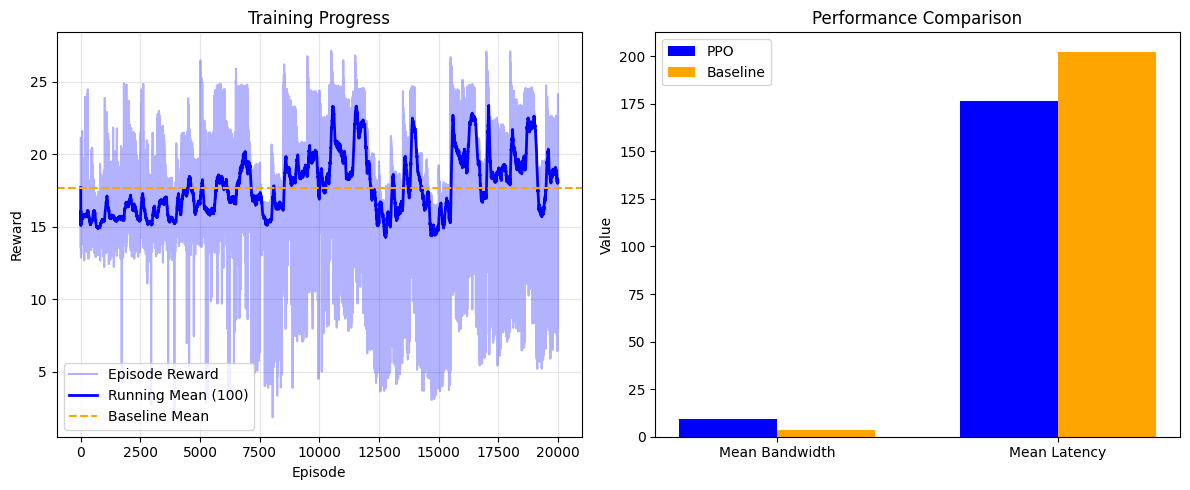

Learning curve saved to learning_curve.png


In [13]:
# Plot training curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards, alpha=0.3, color='blue', label='Episode Reward')
plt.plot(running_mean_100, color='blue', linewidth=2, label='Running Mean (100)')
plt.axhline(y=baseline_metrics['mean_reward'], color='orange', linestyle='--', label='Baseline Mean')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
metrics = ['Mean Bandwidth', 'Mean Latency']
ppo_vals = [ppo_metrics['mean_bandwidth'], ppo_metrics['mean_latency']]
baseline_vals = [baseline_metrics['mean_bandwidth'], baseline_metrics['mean_latency']]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, ppo_vals, width, label='PPO', color='blue')
plt.bar(x + width/2, baseline_vals, width, label='Baseline', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Value')
plt.title('Performance Comparison')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curve.png', dpi=150)
plt.show()

print("Learning curve saved to learning_curve.png")

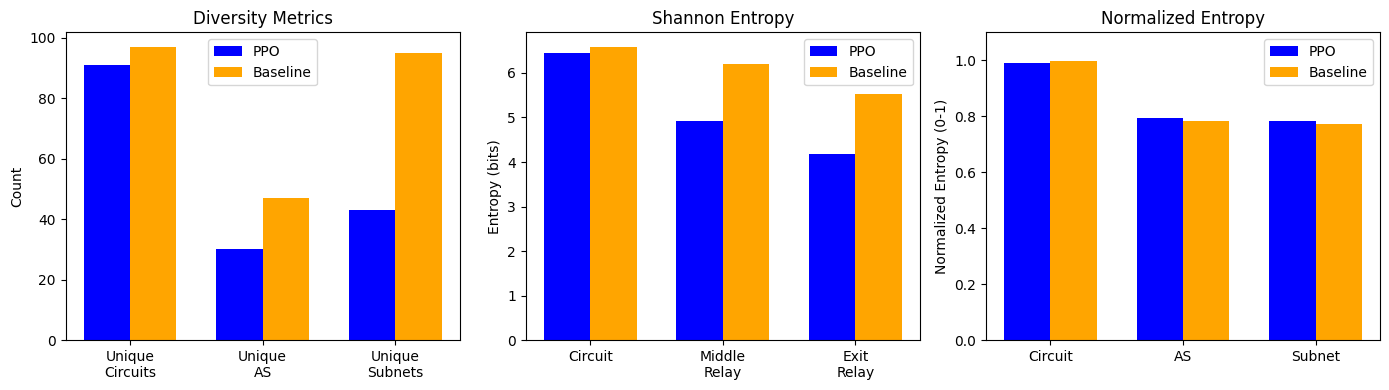

Anonymity metrics saved to anonymity_metrics.png


In [14]:
# Plot anonymity metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Diversity metrics
ax1 = axes[0]
diversity_metrics = ['Unique\nCircuits', 'Unique\nAS', 'Unique\nSubnets']
ppo_div = [ppo_metrics['unique_circuits'], ppo_metrics['unique_as'], ppo_metrics['unique_subnets']]
base_div = [baseline_metrics['unique_circuits'], baseline_metrics['unique_as'], baseline_metrics['unique_subnets']]

x = np.arange(len(diversity_metrics))
ax1.bar(x - width/2, ppo_div, width, label='PPO', color='blue')
ax1.bar(x + width/2, base_div, width, label='Baseline', color='orange')
ax1.set_xticks(x)
ax1.set_xticklabels(diversity_metrics)
ax1.set_ylabel('Count')
ax1.set_title('Diversity Metrics')
ax1.legend()

# Entropy metrics
ax2 = axes[1]
entropy_metrics = ['Circuit', 'Middle\nRelay', 'Exit\nRelay']
ppo_ent = [ppo_metrics['circuit_entropy'], ppo_metrics['middle_relay_entropy'], ppo_metrics['exit_relay_entropy']]
base_ent = [baseline_metrics['circuit_entropy'], baseline_metrics['middle_relay_entropy'], baseline_metrics['exit_relay_entropy']]

x = np.arange(len(entropy_metrics))
ax2.bar(x - width/2, ppo_ent, width, label='PPO', color='blue')
ax2.bar(x + width/2, base_ent, width, label='Baseline', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(entropy_metrics)
ax2.set_ylabel('Entropy (bits)')
ax2.set_title('Shannon Entropy')
ax2.legend()

# Normalized entropy
ax3 = axes[2]
norm_metrics = ['Circuit', 'AS', 'Subnet']
ppo_norm = [ppo_metrics['normalized_circuit_entropy'], ppo_metrics['normalized_as_entropy'], ppo_metrics['normalized_subnet_entropy']]
base_norm = [baseline_metrics['normalized_circuit_entropy'], baseline_metrics['normalized_as_entropy'], baseline_metrics['normalized_subnet_entropy']]

x = np.arange(len(norm_metrics))
ax3.bar(x - width/2, ppo_norm, width, label='PPO', color='blue')
ax3.bar(x + width/2, base_norm, width, label='Baseline', color='orange')
ax3.set_xticks(x)
ax3.set_xticklabels(norm_metrics)
ax3.set_ylabel('Normalized Entropy (0-1)')
ax3.set_title('Normalized Entropy')
ax3.set_ylim(0, 1.1)
ax3.legend()

plt.tight_layout()
plt.savefig('anonymity_metrics.png', dpi=150)
plt.show()

print("Anonymity metrics saved to anonymity_metrics.png")

## 8. Analysis and Discussion

### Key Findings

| Finding | PPO | Baseline | Interpretation |
|---------|-----|----------|----------------|
| **Bandwidth** | 9.36 MB/s | 3.78 MB/s | PPO learns to select high-bandwidth relay combinations |
| **Latency** | 176 ms | 202 ms | Lower latency from avoiding slow relays |
| **Unique Circuits** | 91/100 | 97/100 | Slightly lower diversity, but still high |
| **Circuit Entropy** | 6.45 bits | 6.58 bits | Near-identical unpredictability |

### Why PPO Outperforms the Baseline

1. **Bandwidth optimization**: The baseline weights relays individually, but circuit bandwidth is limited by the slowest relay (bottleneck). PPO learns to select relays with *complementary* high bandwidth across all three positions.

2. **Multi-objective learning**: The reward function jointly optimizes bandwidth, latency, and diversity. The baseline only considers bandwidth weights.

3. **Constraint-aware selection**: Action masking eliminates invalid choices before selection, while the baseline must reject and retry invalid combinations.

### Anonymity Preservation

The PPO agent maintains **99.3% of baseline circuit entropy**, demonstrating that performance optimization does not compromise anonymity:
- High entropy = unpredictable selection = resistant to traffic analysis
- The stochastic nature of PPO policies inherently preserves randomness

### Limitations

1. **Simulation fidelity**: Custom environment, not Shadow simulator or real Tor data
2. **Network scale**: 500 relays vs. ~6,000-7,000 in real Tor network  
3. **No adversarial evaluation**: Haven't tested against traffic correlation attacks
4. **Static Wxx weights**: Real Tor computes these dynamically from consensus

### Future Work

- Validate with Shadow simulator for higher fidelity
- Scale to full 6,000-7,000 relay network
- Evaluate against traffic analysis attacks
- Implement online adaptation with real performance feedback

In [15]:
# Summary statistics
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"\nPPO vs Baseline Improvements:")
print(f"  • Bandwidth: +{bw_improvement:.1f}%")
print(f"  • Latency: -{lat_improvement:.1f}%")
print(f"  • Circuit Entropy Retention: {ppo_metrics['normalized_circuit_entropy']/baseline_metrics['normalized_circuit_entropy']*100:.1f}%")
print(f"\nTraining Details:")
print(f"  • Episodes: {TRAIN_NUM_EPISODES}")
print(f"  • Training Time: {training_time:.1f} seconds")
print(f"  • Final Avg Reward: {np.mean(episode_rewards[-100:]):.2f}")
print("="*60)


SUMMARY

PPO vs Baseline Improvements:
  • Bandwidth: +148.0%
  • Latency: -12.8%
  • Circuit Entropy Retention: 99.3%

Training Details:
  • Episodes: 20000
  • Training Time: 87.7 seconds
  • Final Avg Reward: 18.19
